# 2. Predict Brown Dwarf Parameters Using Trained ML Models


In the following steps, you will: 

We will need the following modules from `TelescopeML`:

- *DataMaster*: to prepare the syntheric brown dwarf dataset, load the trained machine learning (ML) models
- *Predictor*: to prepare the observatinal brown dwarf dataset and deploy the trained ML models
- *StatVisAnalyzer*: provide statistical-test and plotting function  
- *IO_utils*: provide functions to load the trained ML models

In [1]:
from TelescopeML.DataMaster import *
from TelescopeML.Predictor import *
from TelescopeML.StatVisAnalyzer import *
from TelescopeML.IO_utils import load_or_dump_trained_model_CNN

Loading BokehJS ...

Loading BokehJS ...

## 2.1 Load the Brown Dwarf spectra and Trained CNNs models


### 2.1.1 Load the Synthetic spectra - training dataset 

<!-- ### 2.1.1 Load the Synthetic spectra - training dataset -->

We computed a low-resolution spectrum ($R$=200) utilizing atmopshric brown dwarfs grid model, [*Sonora-Bobcat*](https://arxiv.org/pdf/2107.07434.pdf) for spectral range $\sim$0.9-2.4 $\mu m$. An open-source atmospheric radiative transfer Python package, [*PICASO*](https://natashabatalha.github.io/picaso/) was employed for generating these datasets. This dataset encompass 30,888 synthetic spectra (or instances or rows). 

Each spectrum has 104 features (or wavelengths in the astrophysics context, i.e., 0.897, 0.906, ..., 2.512~$\mu$m) and 4 parameters:
- gravity ( log$g$ ) 
- temperature ( T$_{eff}$ )
- carbon-to-oxygen ratio ( C/O )
- metallicity ( [M/H] )

In [2]:
# Read the `TelescopeML_reference_data` path

import os  # to check the path  

__reference_data_path__ = os.getenv("TelescopeML_reference_data")
__reference_data_path__

'/Users/egharibn/RESEARCH/ml/projects/TelescopeML_project/reference_data/'

 Load the dataset and check few instances 

In [3]:
train_BD = pd.read_csv(os.path.join(__reference_data_path__, 
                                    'training_datasets', 
                                    'browndwarf_R100_v4_newWL_v2.csv.bz2'), compression='bz2')
train_BD.head(5)

,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
0,5.0,1100,0.25,-1.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
1,5.0,1100,0.25,-0.7,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
2,5.0,1100,0.25,-0.5,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
3,5.0,1100,0.25,-0.3,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
4,5.0,1100,0.25,0.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no


### 2.1.2 Check atmospheric parameters

- gravity ( log$g$ ) 
- temperature ( T$_{eff}$ )
- carbon-to-oxygen ratio ( C/O )
- metallicity ( [M/H] )

Note: one of the columns, *is_augmented*, is indicating whether this is a native dataset or an augmented one. let's just ignore it for now!

In [4]:
target_features = ['gravity', 'temperature', 'c_o_ratio', 'metallicity']
train_BD[target_features].head()

,gravity,temperature,c_o_ratio,metallicity
0,5.0,1100,0.25,-1.0
1,5.0,1100,0.25,-0.7
2,5.0,1100,0.25,-0.5
3,5.0,1100,0.25,-0.3
4,5.0,1100,0.25,0.0


In [5]:
wl_synthetic = pd.read_csv(os.path.join(__reference_data_path__, 
                                        'training_datasets', 
                                        'wl.csv'))
wl_synthetic.head(3)

,wl
0,2.511960
1,2.486966
2,2.462220


### 2.1.3 Load the trained CNN model

- Load the trained CNN model, which includes:
    - The model parameters to apply it to a given datasets 
    - The training history to check the performance 

In [6]:
trained_CNN_model, trained_CNN_history = load_or_dump_trained_model_CNN(
                                                      output_indicator='Toy_parameters_v4_1000epoch_v2',
                                                      load_or_dump = 'load')

2023-11-14 16:35:21.305065: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 2.1.4 Load the trained data prosessing Scalers

- Load the trained StandardScalers which were trained and utilized to train the CNNs models:
    - trained_StandardScaler_X_ColWise_MinMax 
    - trained_StandardScaler_y_ColWise 

In [7]:
Load_Save = LoadSave(ml_model_str = 'CNN', ml_method = 'regression')

trained_StandardScaler_X_ColWise_MinMax = Load_Save.load_or_dump_trained_object(
                                                     trained_object = None,
                                                     output_indicator = 'Trained_StandardScaler_X_ColWise_MinMax',
                                                     load_or_dump='load')

trained_StandardScaler_y_ColWise = Load_Save.load_or_dump_trained_object(
                                                     trained_object = None,
                                                     output_indicator = 'Trained_StandardScaler_y_ColWise',
                                                     load_or_dump='load')

## 2.2 Predict Brown Dwarf Atmosphric Parameters of HD 3651 B

In the following, we will deploy the trained CNN models to predict atmospheric parameters. Major steps are: 

1. Define the literature reported data for the object 

2. Instintiate *ObsParameterPredictor* class from *Predictor* module

3. Load the observational Telescope data
    - Replace negative Flam with zero
    - Take the average of neibougrs for Flam_error <= 0
    - Plot_observational_spectra_errorbar_
    
    
4. Process the observational Telescope data
    - Instintiate ProcessObservationalDataset class
    - Define feature_names_synthetic and feature_names_obs



### 2.2.1 Load the data and process

Define the literature data reported for this object

This data will be used later to: 
- Compare the Literature vs ML predicted results
- Convert the unit of the real observational dataset or fluxes from $F_\lambda$ to $F_\nu$ and $F_\nu^{absolute}$
- Revised the object radius

In [8]:
HD3651B_BD_literature_info = {
          'bd_name':'HD3651B',
          'bd_Teff':818,
          'bd_logg':3.94,
          'bd_met': -0.22, 
          'bd_distance_pc' : 11.134, 
          'bd_radius_Rjup' : .81,
          'bd_radius_Rjup_tuned': .81} #0.81

brown_dwarf_literature_info = HD3651B_BD_literature_info

<font size="4"> Instintiate the *ObserveParameterPredictor* class from *Predictor* module </font>

*ObserveParameterPredictor* class performs the following tasks:
- Load the observational datasets
- Process the data including converting their units
- Visualize the data

In [9]:
# brown_dwarf_literature_info 
predict = ObserveParameterPredictor(
                                object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                training_dataset_df = train_BD,
                                wl_synthetic = wl_synthetic, 
                                bd_literature_dic = brown_dwarf_literature_info,
                                trained_ML_model = trained_CNN_model,
                                trained_X_ColWise_MinMax=trained_StandardScaler_X_ColWise_MinMax,
                                trained_y_ColWise=trained_StandardScaler_y_ColWise,
                                trained_X_RowWise=None,
                                )

<font size="4">  Load the observational Telescope data </font>


In [10]:
predict.load_observational_spectra(
    __plot_observational_spectra_errorbar__=True,
    __replace_zeros_negatives_with_mean__=True,
    __print_results__=True,
    )

------- Observational DataFrame Example ---------
         wl      F_lambda  F_lambda_error  F_lambda_obs  F_lambda_obs_err
0  0.650857  8.606238e-17    4.358173e-17  8.606238e-17      4.358173e-17
1  0.653073  1.771977e-17    3.360256e-17  1.771977e-17      3.360256e-17
2  0.655278  7.300979e-17    3.132892e-17  7.300979e-17      3.132892e-17
3  0.657472  2.569511e-17    2.837585e-17  2.569511e-17      2.837585e-17
4  0.659659  3.786160e-18    2.497690e-17  3.786160e-18      2.497690e-17


Loading BokehJS ...

### 2.2.2 Process the observational Telescope data

In [11]:
predict.Process_Observational_Dataset(
    __print_results__=True,
    F_lambda_obs=None,
    F_lambda_obs_err=None    )

------------  Interpolated Observational Spectra: Absolute F𝜈 ------------
          0.897         0.906         0.915         0.924         0.933  \
0  5.997174e-09  8.576299e-09  6.022747e-09  1.077888e-08  9.085077e-09   

          0.943         0.952         0.962         0.971         0.981  ...  \
0  1.302502e-08  1.262613e-08  1.206215e-08  1.860160e-08  2.463705e-08  ...   

          2.296         2.319         2.342         2.366         2.389  \
0  7.905764e-09  6.980955e-09  6.795411e-09  4.822663e-09  7.304593e-09   

          2.413         2.438         2.462         2.487         2.512  
0  1.166870e-08  8.334444e-09  1.709369e-08  1.834442e-08  2.162885e-08  

[1 rows x 104 columns]
------------ df_MinMax Single Observational Spectrum ------------
              0             1
0  1.059763e-09  3.096774e-07


******************************

Radius, BD_mean, BD_std:

{   'BD_mean': 5.6044032080948946e-08,
    'BD_std': 6.905598259831068e-08,
    'bd_radius_Rjup': 0.81}
******************************

******************************

Predicted Targets from the Signle Observational Spectrum:

{   'c_o_ratio': 1.24,
    'gravity': 4.97,
    'metallicity': -0.43,
    'temperature': 835.93}
******************************



2023-11-14 16:35:21.629802: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [12]:
predict.obs_data_df.columns

Index(['wl', 'F_lambda', 'F_lambda_error', 'F_lambda_obs', 'F_lambda_obs_err',
       'Fnu_obs', 'Fnu_obs_err', 'Fnu_obs_absolute', 'Fnu_obs_absolute_err'],
      dtype='object')

<font size="4">  Check the processed Telescope dataset </font>

This dataframe includes the following columns:

- **wl (wavelengths in $\mu m$)**: Wavelengths from the observational dataset.

- **F_lambda ($F_\lambda$)**: Original observational spectral density flux along the wavelength axis.
- **F_lambda_error ($F_\lambda^{error}$)**: Original observational spectral density flux uncertainty along the wavelength axis.
- **F_lambda_obs ($F_\lambda^{obs}$)**: Same as the original F_lambda but with a more descriptive label.
- **F_lambda_obs_err ($F_\lambda^{error, obs}$)**: Same as the original F_lambda_error but with a more descriptive label.
- **Fnu_obs ($F_\nu^{obs}$)**: Observational spectral density flux along the frequency axis (converted from the F_lambda column).
- **Fnu_obs_err ($F_\nu^{error}$)**: Observational spectral density flux uncertainty along the frequency axis (converted from the  F_lambda column).
- **Fnu_obs_absolute ($F_\nu^{obs, abs}$)**: Observational absolute spectral density flux along the frequency axis (converted from the F_lambda column).
- **Fnu_obs_absolute_err ($F_\nu^{obs, abs, error}$)**: Observational absolute spectral density flux uncertainty along the frequency axis (converted from the F_lambda column).



In [13]:
predict.obs_data_df.head(6)

,wl,F_lambda,F_lambda_error,F_lambda_obs,F_lambda_obs_err,Fnu_obs,Fnu_obs_err,Fnu_obs_absolute,Fnu_obs_absolute_err
0,0.650857,8.606238e-17,4.358173e-17,8.606238e-17,4.358173e-17,1.216085e-27,6.158216e-28,4.280381e-08,2.167572e-08
1,0.653073,1.771977e-17,3.360256e-17,1.771977e-17,3.360256e-17,2.520930e-28,4.780520e-28,8.873182e-09,1.682650e-08
2,0.655278,7.300979e-17,3.132892e-17,7.300979e-17,3.132892e-17,1.045711e-27,4.487205e-28,3.680698e-08,1.579409e-08
3,0.657472,2.569511e-17,2.837585e-17,2.569511e-17,2.837585e-17,3.704967e-28,4.091501e-28,1.304076e-08,1.440129e-08
4,0.659659,3.786160e-18,2.497690e-17,3.786160e-18,2.497690e-17,5.495628e-29,3.625408e-28,1.934354e-09,1.276073e-08
5,0.661837,1.798661e-17,2.475434e-17,1.798661e-17,2.475434e-17,2.628032e-28,3.616868e-28,9.250161e-09,1.273067e-08


### 2.2.3 Deploy the Trained ML Models for Prediction: 

<font size="4"> *predict_from_random_spectra* function from *Predictor* class to perform the following tasks: </font>
    
- Generate random spectra based on the observational data

- Deploy the trained ML models to predict the target outputs: 
    - gravity ( log$g$ )
    - temperature ( T$_{eff}$ )
    - carbon-to-oxygen ratio ( C/O )
    - metallicity ( [M/H] )

- Print the results, including:
    - Predicted Targets from Randomly Generated Spectra.
    - Print a summary of descriptive statistics, including the mean, standard deviation, and the shape of a dataset's distribution (percentiles).

- Visualize the results to gain insights about:
    - *Histograms* representing the distribution of the predicted target outputs by the trained ML models.
    - *Boxplots* displaying the first quartile, median, third quartile, and maximum. In a box plot, the box is drawn from the first quartile to the third quartile. A vertical black line goes through the box at the median, and a vertical white line goes through the box to indicate the mean.


******************************

Predicted Targets from Randomly Generated Spectra:

{   'c_o_ratio': 1.3601913452148438,
    'gravity': 5.05228853225708,
    'metallicity': -0.36652565002441406,
    'temperature': 811.0637817382812}
******************************

            logg        c_o        met           T
count  30.000000  30.000000  30.000000   30.000000
mean    5.052289   1.360191  -0.366526  811.063782
std     0.155951   0.201710   0.093422   27.624043
min     4.694567   0.992253  -0.463504  763.456177
25%     4.953236   1.215818  -0.433333  790.705673
50%     5.081181   1.376375  -0.391097  809.184021
75%     5.183164   1.532978  -0.332025  826.896973
max     5.275113   1.864724  -0.087467  868.020935


<Figure size 640x480 with 0 Axes>

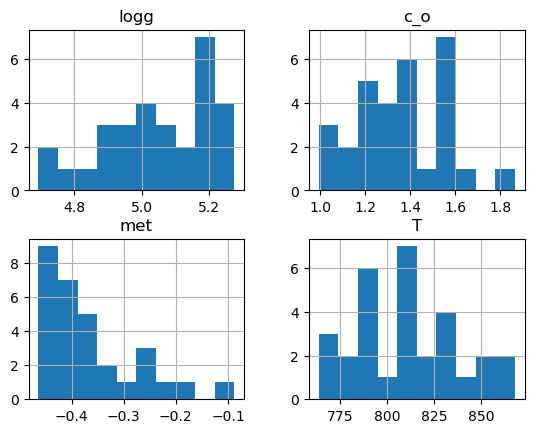

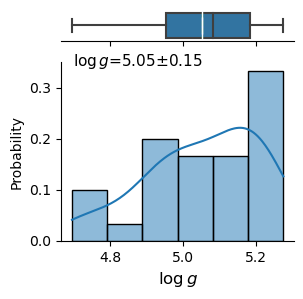

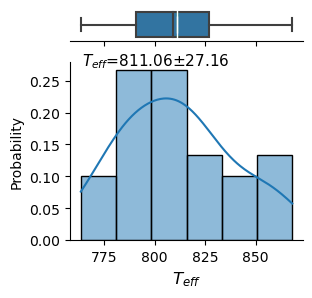

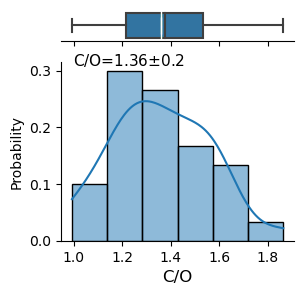

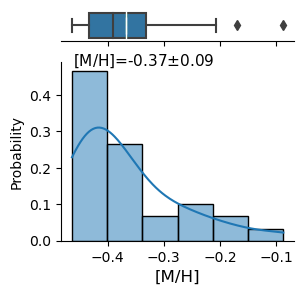

Radius = 0.81 R_Jup:  𝛘2 = 124.32, p-value = 7.50e-02


In [14]:
predict.predict_from_random_spectra(random_spectra_num= 30,
                                     __print_results__= True,
                                     __plot_randomly_generated_spectra__= True,
                                     __plot_histogram__= True,
                                     __plot_boxplot_hist__= True,
                                     __plot_pred_vs_obs_errorbar__= True,
                                     __plot_pred_vs_obs_errorbar_stat__ = True,
                                     __calculate_confidence_intervals_std_df__ = True,
                                    )

### 2.2.4 Tune the Radius

What is the 𝛘2 value for the predicted ML vs. the observational spectra?

In [15]:
chi_square_test(x_obs = predict.obs_data_df['wl'], 
                y_obs = predict.obs_data_df['Fnu_obs_absolute'], 
                yerr_obs = predict.obs_data_df['Fnu_obs_absolute_err'],
                
                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                y_pre = predict.confidence_intervals_std_df['mean'], 
                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                radius = brown_dwarf_literature_info['bd_radius_Rjup'],
                __plot_results__ = False,
                __print_results__ = True)

Radius = 0.81 R_Jup:  𝛘2 = 124.32, p-value = 7.50e-02


(124.32, '7.50e-02')

 What is the 𝛘2 value (and p-value) for a range of $R_{Jup}$ radius? 

In [16]:
def tune_radius(Rmin = brown_dwarf_literature_info['bd_radius_Rjup']-0.1, 
                Rmax = brown_dwarf_literature_info['bd_radius_Rjup']+0.1, 
                dR=0.01,
                brown_dwarf_literature_info = None,
                __plot_results__ = False,
               __print_results__ = False,
               __plot_stat_results__ = False):
    
    R_list = []
    chi_square_list = []
    p_value_list = []
    random_pred_mean_list = []
 

    for radius in list( np.linspace(Rmin, Rmax, num=int((Rmax-Rmin)/dR) )):
        
        brown_dwarf_literature_info['bd_radius_Rjup_tuned'] = radius
        
        # brown_dwarf_literature_info = Ross458C_BD_literature_info
        predict = ObserveParameterPredictor(object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                        training_dataset_df = train_BD,
                                        wl_synthetic = wl_synthetic, 
                                        bd_literature_dic = brown_dwarf_literature_info,
                                        trained_ML_model=trained_CNN_model,
                                        trained_X_ColWise_MinMax=trained_StandardScaler_X_ColWise_MinMax,
                                        trained_y_ColWise=trained_StandardScaler_y_ColWise,
                                        trained_X_RowWise=None,
                                           )

        predict.load_observational_spectra(
            __plot_observational_spectra_errorbar__=False,
            __replace_zeros_negatives_with_mean__=True,
            __print_results__=False,
            )
        
        predict.Process_Observational_Dataset(
            __print_results__=False,
            F_lambda_obs=None,
            F_lambda_obs_err=None    
                )

        predict.predict_from_random_spectra(random_spectra_num= 3,
                                             __print_results__= False,
                                             __plot_randomly_generated_spectra__= False,
                                             __plot_histogram__= False,
                                             __plot_boxplot_hist__= False,
                                             __plot_pred_vs_obs_errorbar__= False,
                                             __plot_pred_vs_obs_errorbar_stat__ = False,
                                             __calculate_confidence_intervals_std_df__ = True,
                                            )

        chi_square, p_value =  chi_square_test(x_obs = predict.obs_data_df['wl'], 
                                y_obs = predict.obs_data_df['Fnu_obs_absolute'], 
                                yerr_obs = predict.obs_data_df['Fnu_obs_absolute_err'],

                                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                                y_pre = predict.confidence_intervals_std_df['mean'], 
                                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                                radius = brown_dwarf_literature_info['bd_radius_Rjup'],
                                __plot_results__ = False,
                                __print_results__ = False)
        
        
        if chi_square >= 0.:

            R_list.append(radius)
            chi_square_list.append(chi_square)
            p_value_list.append(np.float64(p_value))
            random_pred_mean_list.append(list( predict.dic_random_pred_mean.values() ))
        else:
            pass

        if __print_results__:
            print( f"Radius = {'{:.2f}'.format(radius)} R_Jup:  𝛘2 = {chi_square}, p-value = {p_value}")
            
#     if __plot_stat_results__:
#         plot_chi_square_p_value(R_list, chi_square_list, p_value_list)
    
    tuned_ML_R_param_df = pd.DataFrame(columns=['radius','chi_square','p_value','gravity','temperature','c_o_ratio','metallicity'])
    tuned_ML_R_param_df['radius'] = R_list
    tuned_ML_R_param_df['chi_square'] = chi_square_list
    tuned_ML_R_param_df['p_value'] = p_value_list
    tuned_ML_R_param_df['gravity'] = np.array(random_pred_mean_list).T[0]
    tuned_ML_R_param_df['c_o_ratio'] = np.array(random_pred_mean_list).T[1]
    tuned_ML_R_param_df['metallicity'] = np.array(random_pred_mean_list).T[2]
    tuned_ML_R_param_df['temperature'] = np.array(random_pred_mean_list).T[3]

    return tuned_ML_R_param_df

In [17]:
print_results_fun(brown_dwarf_literature_info, print_title= 'HD3651B: Literature reported Info')

******************************

HD3651B: Literature reported Info

{   'bd_Teff': 818,
    'bd_distance_pc': 11.134,
    'bd_logg': 3.94,
    'bd_met': -0.22,
    'bd_name': 'HD3651B',
    'bd_radius_Rjup': 0.81,
    'bd_radius_Rjup_tuned': 0.81}
******************************



In [18]:
tuned_ML_R_param_df = tune_radius(Rmin = brown_dwarf_literature_info['bd_radius_Rjup']- 0.2, 
                        Rmax = brown_dwarf_literature_info['bd_radius_Rjup']+ 0.2, 
                        dR = 0.05,
                        brown_dwarf_literature_info = brown_dwarf_literature_info,
                        __plot_results__=False,
                        __print_results__=False,
                        __plot_stat_results__=False,)

In [19]:
tuned_ML_R_param_df.describe()

,radius,chi_square,p_value,gravity,temperature,c_o_ratio,metallicity
count,7.000000,7.000000,7.000000e+00,7.000000,7.000000,7.000000,7.000000
mean,0.810000,207.587143,4.451429e-01,5.003806,811.807486,1.436071,-0.330420
std,0.144016,193.961842,5.181121e-01,0.134421,21.049365,0.249100,0.055992
min,0.610000,35.090000,0.000000e+00,4.830354,786.609680,1.157647,-0.384225
25%,0.710000,58.515000,4.645000e-13,4.911439,796.442871,1.288718,-0.362450
50%,0.810000,119.640000,1.250000e-01,5.005306,814.126282,1.376148,-0.350007
75%,0.910000,334.795000,9.955000e-01,5.086114,820.578796,1.567765,-0.310431
max,1.010000,511.760000,1.000000e+00,5.195873,847.873108,1.805733,-0.232948


In [20]:
tuned_ML_R_param_df.head()

,radius,chi_square,p_value,gravity,temperature,c_o_ratio,metallicity
0,0.610000,44.92,1.000000e+00,5.128405,814.126282,1.754416,-0.354383
1,0.676667,431.07,0.000000e+00,5.195873,814.887268,1.805733,-0.350007
2,0.743333,238.52,9.290000e-13,5.005306,826.270325,1.376148,-0.232948
3,0.810000,119.64,1.250000e-01,4.851244,792.794739,1.346838,-0.370517
4,0.876667,511.76,0.000000e+00,5.043823,847.873108,1.230598,-0.271380


In [21]:

datuned_ML_R_param_df_filtered = tuned_ML_R_param_df[tuned_ML_R_param_df['p_value'].between(.04, 1.)]

plot_scatter_x_y(   x = datuned_ML_R_param_df_filtered['radius'],
                    y = datuned_ML_R_param_df_filtered['chi_square'],
                    plot_title='Scatter Plot',
                    x_label='Radius (RJupiter)',
                    y_label='𝛘2 value',
                    plot_width=800,
                    plot_height=300,)

---

## 2.3 Predict Brown Dwarf Atmosphric Parameters of Ross 458C 

In the following, we will deploy the trained CNN models to predict atmospheric parameters. Major steps are: 

1. Define the literature reported data for the object 

2. Instintiate *ObsParameterPredictor* class from *Predictor* module

3. Load the observational Telescope data
    - Replace negative Flam with zero
    - Take the average of neibougrs for Flam_error <= 0
    - Plot_observational_spectra_errorbar_
    
    
4. Process the observational Telescope data
    - Instintiate ProcessObservationalDataset class
    - Define feature_names_synthetic and feature_names_obs



### 2.3.1 Load the data and process

Define the literature data reported for this object

This data will be used later to: 
- Compare the Literature vs ML predicted results
- Convert the unit of the real observational dataset or fluxes from $F_\lambda$ to $F_\nu$ and $F_\nu^{absolute}$
- Revised the object radius

In [22]:
Ross458C_BD_literature_info = {'bd_name':'Ross458C',
          'bd_Teff':804,
          'bd_logg':4.09,
          'bd_met': 0.23, 
          'bd_distance_pc' : 11.509, 
          'bd_radius_Rjup' :  0.68,
          'bd_radius_Rjup_tuned': None } #1.0 * 0.68 

brown_dwarf_literature_info = Ross458C_BD_literature_info

<font size="4"> Instintiate the *ObserveParameterPredictor* class from *Predictor* module </font>

*ObserveParameterPredictor* class performs the following tasks:
- Load the observational datasets
- Process the data including converting their units
- Visualize the data

In [23]:
# brown_dwarf_literature_info 
predict = ObserveParameterPredictor(
                                object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                training_dataset_df = train_BD,
                                wl_synthetic = wl_synthetic, 
                                bd_literature_dic = brown_dwarf_literature_info,
                                trained_ML_model = trained_CNN_model,
                                trained_X_ColWise_MinMax=trained_StandardScaler_X_ColWise_MinMax,
                                trained_y_ColWise=trained_StandardScaler_y_ColWise,
                                trained_X_RowWise=None,
                                )

<font size="4">  Load the observational Telescope data </font>


In [24]:
predict.load_observational_spectra(
    __plot_observational_spectra_errorbar__=True,
    __replace_zeros_negatives_with_mean__=True,
    __print_results__=True,
    )

------- Observational DataFrame Example ---------
         wl      F_lambda  F_lambda_error  F_lambda_obs  F_lambda_obs_err
0  0.692196  1.896532e-18    3.679267e-18  1.896532e-18      3.679267e-18
1  0.693680 -8.169787e-18    3.527262e-18  1.025778e-18      3.527262e-18
2  0.695165  1.550241e-19    3.538419e-18  1.550241e-19      3.538419e-18
3  0.696652  2.584982e-18    3.294942e-18  2.584982e-18      3.294942e-18
4  0.698140  2.829340e-18    3.251767e-18  2.829340e-18      3.251767e-18


Loading BokehJS ...

### 2.3.2 Process the observational Telescope data

In [25]:
predict.Process_Observational_Dataset(
    __print_results__=True,
    F_lambda_obs=None,
    F_lambda_obs_err=None    )

------------  Interpolated Observational Spectra: Absolute F𝜈 ------------
          0.897         0.906         0.915         0.924         0.933  \
0  7.431980e-09  6.772274e-09  7.564100e-09  9.779585e-09  6.589324e-09   

          0.943         0.952         0.962         0.971         0.981  ...  \
0  1.186165e-08  1.168911e-08  1.217457e-08  1.491817e-08  1.867662e-08  ...   

          2.296         2.319         2.342         2.366         2.389  \
0  1.675178e-08  2.010950e-08  7.911809e-09  1.281873e-08  1.298326e-08   

          2.413         2.438         2.462         2.487         2.512  
0  2.857164e-08  4.066384e-08  4.169449e-08  1.412377e-07  1.428379e-07  

[1 rows x 104 columns]
------------ df_MinMax Single Observational Spectrum ------------
              0             1
0  2.687596e-09  2.890186e-07
******************************

Radius, BD_mean, BD_std:

{   'BD_mean': 6.724862374473837e-08,
    'BD_std': 7.044146438046857e-08,
    'bd_radius_Rjup': 0.68}
***

<font size="4">  Check the processed Telescope dataset </font>

This dataframe includes the following columns:

- **wl (wavelengths in $\mu m$)**: Wavelengths from the observational dataset.

- **F_lambda ($F_\lambda$)**: Original observational spectral density flux along the wavelength axis.
- **F_lambda_error ($F_\lambda^{error}$)**: Original observational spectral density flux uncertainty along the wavelength axis.
- **F_lambda_obs ($F_\lambda^{obs}$)**: Same as the original F_lambda but with a more descriptive label.
- **F_lambda_obs_err ($F_\lambda^{error, obs}$)**: Same as the original F_lambda_error but with a more descriptive label.
- **Fnu_obs ($F_\nu^{obs}$)**: Observational spectral density flux along the frequency axis (converted from the F_lambda column).
- **Fnu_obs_err ($F_\nu^{error}$)**: Observational spectral density flux uncertainty along the frequency axis (converted from the  F_lambda column).
- **Fnu_obs_absolute ($F_\nu^{obs, abs}$)**: Observational absolute spectral density flux along the frequency axis (converted from the F_lambda column).
- **Fnu_obs_absolute_err ($F_\nu^{obs, abs, error}$)**: Observational absolute spectral density flux uncertainty along the frequency axis (converted from the F_lambda column).


In [26]:
predict.obs_data_df.head()

,wl,F_lambda,F_lambda_error,F_lambda_obs,F_lambda_obs_err,Fnu_obs,Fnu_obs_err,Fnu_obs_absolute,Fnu_obs_absolute_err
0,0.692196,1.896532e-18,3.679267e-18,1.896532e-18,3.679267e-18,3.031078e-29,5.880282e-29,1.617486e-09,3.137919e-09
1,0.693680,-8.169787e-18,3.527262e-18,1.025778e-18,3.527262e-18,1.646459e-29,5.661549e-29,8.786066e-10,3.021195e-09
2,0.695165,1.550241e-19,3.538419e-18,1.550241e-19,3.538419e-18,2.498932e-30,5.703804e-29,1.333515e-10,3.043744e-09
3,0.696652,2.584982e-18,3.294942e-18,2.584982e-18,3.294942e-18,4.184739e-29,5.334067e-29,2.233119e-09,2.846440e-09
4,0.698140,2.829340e-18,3.251767e-18,2.829340e-18,3.251767e-18,4.599908e-29,5.286686e-29,2.454668e-09,2.821156e-09


### 2.3.3 Deploy the Trained ML Models for Prediction: 

<font size="4"> *predict_from_random_spectra* function from *Predictor* class to perform the following tasks: </font>
    
- Generate random spectra based on the observational data

- Deploy the trained ML models to predict the target outputs: 
    - gravity ( log$g$ )
    - temperature ( T$_{eff}$ )
    - carbon-to-oxygen ratio ( C/O )
    - metallicity ( [M/H] )

- Print the results, including:
    - Predicted Targets from Randomly Generated Spectra.
    - Print a summary of descriptive statistics, including the mean, standard deviation, and the shape of a dataset's distribution (percentiles).

- Visualize the results to gain insights about:
    - *Histograms* representing the distribution of the predicted target outputs by the trained ML models.
    - *Boxplots* displaying the first quartile, median, third quartile, and maximum. In a box plot, the box is drawn from the first quartile to the third quartile. A vertical black line goes through the box at the median, and a vertical white line goes through the box to indicate the mean.


******************************

Predicted Targets from Randomly Generated Spectra:

{   'c_o_ratio': 1.174254298210144,
    'gravity': 4.7387213706970215,
    'metallicity': 0.8516557812690735,
    'temperature': 960.212646484375}
******************************

            logg        c_o        met            T
count  30.000000  30.000000  30.000000    30.000000
mean    4.738721   1.174254   0.851656   960.212646
std     0.228793   0.126961   0.113681    42.885548
min     4.267989   0.997774   0.630569   850.807861
25%     4.627554   1.097652   0.790724   933.027542
50%     4.791363   1.132675   0.841744   966.968567
75%     4.882944   1.217234   0.905694   992.384613
max     5.271516   1.520150   1.085326  1023.224976


<Figure size 640x480 with 0 Axes>

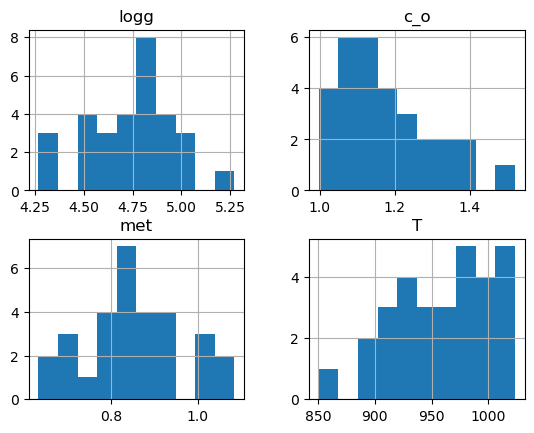

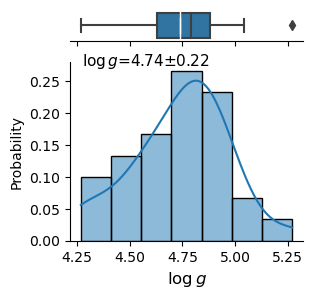

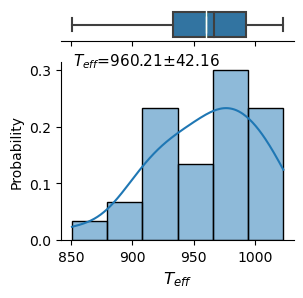

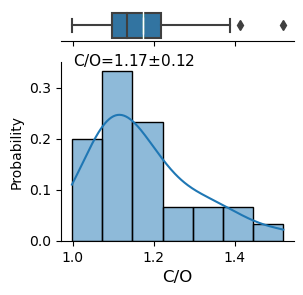

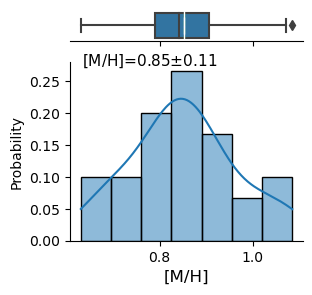

Radius = 0.68 R_Jup:  𝛘2 = 108.67, p-value = 3.32e-01


In [27]:
predict.predict_from_random_spectra(random_spectra_num= 30,
                                     __print_results__= True,
                                     __plot_randomly_generated_spectra__= True,
                                     __plot_histogram__= True,
                                     __plot_boxplot_hist__= True,
                                     __plot_pred_vs_obs_errorbar__= True,
                                     __plot_pred_vs_obs_errorbar_stat__ = True,
                                     __calculate_confidence_intervals_std_df__ = True,
                                    )

Comennet from natasha: >2.2 mincron - Is not missing any thing!
> 1 sigma error 
> training set
> trusing the posterior space 

### 2.3.4 Tune the Radius

 What is the 𝛘2 value for the predicted ML vs. the observational spectra?

In [28]:
chi_square_test(x_obs = predict.obs_data_df['wl'], 
                y_obs = predict.obs_data_df['Fnu_obs_absolute'], 
                yerr_obs = predict.obs_data_df['Fnu_obs_absolute_err'],
                
                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                y_pre = predict.confidence_intervals_std_df['mean'], 
                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                radius = brown_dwarf_literature_info['bd_radius_Rjup'],
                __plot_results__ = False,
                __print_results__ = True)

Radius = 0.68 R_Jup:  𝛘2 = 108.67, p-value = 3.32e-01


(108.67, '3.32e-01')

 What is the 𝛘2 value (and p-value) for a range of $R_{Jup}$ radius?

In [29]:
def tune_radius(Rmin = brown_dwarf_literature_info['bd_radius_Rjup']-0.1, 
                Rmax = brown_dwarf_literature_info['bd_radius_Rjup']+0.1, 
                dR=0.01,
                brown_dwarf_literature_info = None,
                __plot_results__ = False,
               __print_results__ = False,
               __plot_stat_results__ = False):
    
    R_list = []
    chi_square_list = []
    p_value_list = []
    random_pred_mean_list = []
 

    for radius in list( np.linspace(Rmin, Rmax, num=int((Rmax-Rmin)/dR) )):
        
        brown_dwarf_literature_info['bd_radius_Rjup_tuned'] = radius
        
        # brown_dwarf_literature_info 
        predict = ObserveParameterPredictor(
                                        object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                        training_dataset_df = train_BD,
                                        wl_synthetic = wl_synthetic, 
                                        bd_literature_dic = brown_dwarf_literature_info,
                                        trained_ML_model = trained_CNN_model,
                                        trained_X_ColWise_MinMax=trained_StandardScaler_X_ColWise_MinMax,
                                        trained_y_ColWise=trained_StandardScaler_y_ColWise,
                                        trained_X_RowWise=None,
                                        )

        predict.load_observational_spectra(
            __plot_observational_spectra_errorbar__=False,
            __replace_zeros_negatives_with_mean__=True,
            __print_results__=False,
            )
        
        predict.Process_Observational_Dataset(
            __print_results__=False,
            F_lambda_obs=None,
            F_lambda_obs_err=None    
                )

        predict.predict_from_random_spectra(random_spectra_num= 3,
                                             __print_results__= False,
                                             __plot_randomly_generated_spectra__= False,
                                             __plot_histogram__= False,
                                             __plot_boxplot_hist__= False,
                                             __plot_pred_vs_obs_errorbar__= False,
                                             __plot_pred_vs_obs_errorbar_stat__ = False,
                                             __calculate_confidence_intervals_std_df__ = True,
                                            )

        chi_square, p_value =  chi_square_test(x_obs = predict.obs_data_df['wl'], 
                                y_obs = predict.obs_data_df['Fnu_obs_absolute'], 
                                yerr_obs = predict.obs_data_df['Fnu_obs_absolute_err'],

                                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                                y_pre = predict.confidence_intervals_std_df['mean'], 
                                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                                radius = brown_dwarf_literature_info['bd_radius_Rjup'],
                                __plot_results__ = False,
                                __print_results__ = False)
        
        
        if chi_square >= 0.:

            R_list.append(radius)
            chi_square_list.append(chi_square)
            p_value_list.append(np.float64(p_value))
            random_pred_mean_list.append(list( predict.dic_random_pred_mean.values() ))
        else:
            pass

        if __print_results__:
            print( f"Radius = {'{:.2f}'.format(radius)} R_Jup:  𝛘2 = {chi_square}, p-value = {p_value}")
            
#     if __plot_stat_results__:
#         plot_chi_square_p_value(R_list, chi_square_list, p_value_list)
    
    tuned_ML_R_param_df = pd.DataFrame(columns=['radius','chi_square','p_value','gravity','temperature','c_o_ratio','metallicity'])
    tuned_ML_R_param_df['radius'] = R_list
    tuned_ML_R_param_df['chi_square'] = chi_square_list
    tuned_ML_R_param_df['p_value'] = p_value_list
    tuned_ML_R_param_df['gravity'] = np.array(random_pred_mean_list).T[0]
    tuned_ML_R_param_df['c_o_ratio'] = np.array(random_pred_mean_list).T[1]
    tuned_ML_R_param_df['metallicity'] = np.array(random_pred_mean_list).T[2]
    tuned_ML_R_param_df['temperature'] = np.array(random_pred_mean_list).T[3]

    return tuned_ML_R_param_df

In [30]:
print_results_fun(brown_dwarf_literature_info, print_title= 'Ross458C: Literature reported Info')

******************************

Ross458C: Literature reported Info

{   'bd_Teff': 804,
    'bd_distance_pc': 11.509,
    'bd_logg': 4.09,
    'bd_met': 0.23,
    'bd_name': 'Ross458C',
    'bd_radius_Rjup': 0.68,
    'bd_radius_Rjup_tuned': None}
******************************



In [31]:
tuned_ML_R_param_df = tune_radius(Rmin = brown_dwarf_literature_info['bd_radius_Rjup']- 0.2, 
                        Rmax = brown_dwarf_literature_info['bd_radius_Rjup']+ 0.2, 
                        dR = 0.05,
                        brown_dwarf_literature_info = brown_dwarf_literature_info,
                        __plot_results__=False,
                        __print_results__=False,
                        __plot_stat_results__=False,)

In [32]:
tuned_ML_R_param_df.describe()

,radius,chi_square,p_value,gravity,temperature,c_o_ratio,metallicity
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,0.680000,173.020000,0.211734,4.681444,944.843582,1.147953,0.845103
std,0.139971,86.730694,0.385298,0.092323,28.908973,0.071640,0.065983
min,0.480000,86.260000,0.000000,4.559733,901.217712,1.010017,0.741656
25%,0.580000,124.555000,0.000051,4.610908,928.506012,1.119889,0.829111
50%,0.680000,148.655000,0.003752,4.695778,950.855408,1.164035,0.856839
75%,0.780000,193.547500,0.209475,4.732595,956.210983,1.180993,0.873778
max,0.880000,333.400000,0.883000,4.832422,993.824219,1.250442,0.930534


In [33]:
tuned_ML_R_param_df.head()

,radius,chi_square,p_value,gravity,temperature,c_o_ratio,metallicity
0,0.480000,167.01,0.000068,4.729595,993.824219,1.176864,0.930534
1,0.537143,273.16,0.000000,4.741594,952.163635,1.097496,0.855772
2,0.594286,333.40,0.000000,4.559733,954.811096,1.127353,0.753515
3,0.651429,141.72,0.006870,4.832422,960.410645,1.193378,0.903146
4,0.708571,86.26,0.883000,4.713444,949.547180,1.010017,0.854310


In [34]:

datuned_ML_R_param_df_filtered = tuned_ML_R_param_df[tuned_ML_R_param_df['p_value'].between(.04, 1.)]

plot_scatter_x_y(   x = datuned_ML_R_param_df_filtered['radius'],
                    y = datuned_ML_R_param_df_filtered['chi_square'],
                    plot_title='Scatter Plot',
                    x_label='Radius (RJupiter)',
                    y_label='𝛘2 value',
                    plot_width=800,
                    plot_height=300,)

---

## 2.4 Predict Brown Dwarf Atmosphric Parameters of GJ 570D

In the following, we will deploy the trained CNN models to predict atmospheric parameters. Major steps are: 

1. Define the literature reported data for the object 

2. Instintiate *ObsParameterPredictor* class from *Predictor* module

3. Load the observational Telescope data
    - Replace negative Flam with zero
    - Take the average of neibougrs for Flam_error <= 0
    - Plot_observational_spectra_errorbar_
    
    
4. Process the observational Telescope data
    - Instintiate ProcessObservationalDataset class
    - Define feature_names_synthetic and feature_names_obs




### 2.4.1 Load the data and process

Define the literature data reported for this object

This data will be used later to: 
- Compare the Literature vs ML predicted results
- Convert the unit of the real observational dataset or fluxes from $F_\lambda$ to $F_\nu$ and $F_\nu^{absolute}$
- Revised the object radius

In [35]:
GJ570D_BD_literature_info = {'bd_name':'GJ570D',
          'bd_Teff':828,
          'bd_logg':3.90,
          'bd_met': -0.33, 
          'bd_distance_pc' : 5.884, 
          'bd_radius_Rjup' : 0.79,
          'bd_radius_Rjup_tuned': None } # 0.79

brown_dwarf_literature_info = GJ570D_BD_literature_info

<font size="4"> Instintiate the *ObserveParameterPredictor* class from *Predictor* module </font>

*ObserveParameterPredictor* class performs the following tasks:
- Load the observational datasets
- Process the data including converting their units
- Visualize the data

In [36]:
# brown_dwarf_literature_info 
predict = ObserveParameterPredictor(
                                object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                training_dataset_df = train_BD,
                                wl_synthetic = wl_synthetic, 
                                bd_literature_dic = brown_dwarf_literature_info,
                                trained_ML_model = trained_CNN_model,
                                trained_X_ColWise_MinMax=trained_StandardScaler_X_ColWise_MinMax,
                                trained_y_ColWise=trained_StandardScaler_y_ColWise,
                                trained_X_RowWise=None,
                                )

<font size="4">  Load the observational Telescope data </font>


In [37]:
predict.load_observational_spectra(
    __plot_observational_spectra_errorbar__=True,
    __replace_zeros_negatives_with_mean__=True,
    __print_results__=True,
    )

------- Observational DataFrame Example ---------
         wl      F_lambda  F_lambda_error  F_lambda_obs  F_lambda_obs_err
0  0.657971  4.569383e-17    7.119990e-17  4.569383e-17      7.119990e-17
1  0.660155 -2.299240e-17    0.000000e+00  4.581152e-17      7.541037e-17
2  0.662332 -4.419588e-17    0.000000e+00  4.592921e-17      7.962084e-17
3  0.664501 -9.488424e-18    0.000000e+00  4.604690e-17      8.383131e-17
4  0.666665  4.616459e-17    8.804178e-17  4.616459e-17      8.804178e-17


Loading BokehJS ...

### 2.4.2 Process the observational Telescope data

In [38]:
predict.Process_Observational_Dataset(
    __print_results__=True,
    F_lambda_obs=None,
    F_lambda_obs_err=None    )

------------  Interpolated Observational Spectra: Absolute F𝜈 ------------
          0.897         0.906         0.915         0.924         0.933  \
0  7.280711e-09  8.611113e-09  1.062637e-08  1.170489e-08  7.329417e-09   

          0.943         0.952         0.962         0.971         0.981  ...  \
0  1.371097e-08  1.299396e-08  1.443783e-08  1.943760e-08  2.911763e-08  ...   

          2.296         2.319         2.342         2.366         2.389  \
0  7.612835e-09  6.693866e-09  8.187037e-09  8.760881e-09  8.572828e-09   

          2.413         2.438         2.462         2.487         2.512  
0  1.231363e-08  1.863393e-08  1.684466e-08  2.206102e-08  1.915624e-08  

[1 rows x 104 columns]
------------ df_MinMax Single Observational Spectrum ------------
              0             1
0  1.670937e-09  3.343356e-07
******************************

Radius, BD_mean, BD_std:

{   'BD_mean': 5.960877683707767e-08,
    'BD_std': 7.325304103971966e-08,
    'bd_radius_Rjup': 0.79}
***

<font size="4">  Check the processed Telescope dataset </font>

This dataframe includes the following columns:

- **wl (wavelengths in $\mu m$)**: Wavelengths from the observational dataset.

- **F_lambda ($F_\lambda$)**: Original observational spectral density flux along the wavelength axis.
- **F_lambda_error ($F_\lambda^{error}$)**: Original observational spectral density flux uncertainty along the wavelength axis.
- **F_lambda_obs ($F_\lambda^{obs}$)**: Same as the original F_lambda but with a more descriptive label.
- **F_lambda_obs_err ($F_\lambda^{error, obs}$)**: Same as the original F_lambda_error but with a more descriptive label.
- **Fnu_obs ($F_\nu^{obs}$)**: Observational spectral density flux along the frequency axis (converted from the F_lambda column).
- **Fnu_obs_err ($F_\nu^{error}$)**: Observational spectral density flux uncertainty along the frequency axis (converted from the  F_lambda column).
- **Fnu_obs_absolute ($F_\nu^{obs, abs}$)**: Observational absolute spectral density flux along the frequency axis (converted from the F_lambda column).
- **Fnu_obs_absolute_err ($F_\nu^{obs, abs, error}$)**: Observational absolute spectral density flux uncertainty along the frequency axis (converted from the F_lambda column).


In [39]:
predict.obs_data_df.head(6)

,wl,F_lambda,F_lambda_error,F_lambda_obs,F_lambda_obs_err,Fnu_obs,Fnu_obs_err,Fnu_obs_absolute,Fnu_obs_absolute_err
0,0.657971,4.569383e-17,7.119990e-17,4.569383e-17,7.119990e-17,6.598578e-28,1.028187e-27,6.819110e-09,1.062550e-08
1,0.660155,-2.299240e-17,0.000000e+00,4.581152e-17,7.541037e-17,6.659565e-28,1.096231e-27,6.882135e-09,1.132869e-08
2,0.662332,-4.419588e-17,0.000000e+00,4.592921e-17,7.962084e-17,6.720781e-28,1.165085e-27,6.945398e-09,1.204023e-08
3,0.664501,-9.488424e-18,0.000000e+00,4.604690e-17,8.383131e-17,6.782206e-28,1.234744e-27,7.008875e-09,1.276010e-08
4,0.666665,4.616459e-17,8.804178e-17,4.616459e-17,8.804178e-17,6.843899e-28,1.305219e-27,7.072630e-09,1.348841e-08
5,0.668824,-4.426288e-17,0.000000e+00,4.311795e-17,6.684875e-17,6.433704e-28,9.974619e-28,6.648725e-09,1.030798e-08


### 2.4.3 Deploy the Trained ML Models for Prediction: 

<font size="4"> *predict_from_random_spectra* function from *Predictor* class to perform the following tasks: </font>
    
- Generate random spectra based on the observational data

- Deploy the trained ML models to predict the target outputs: 
    - gravity ( log$g$ )
    - temperature ( T$_{eff}$ )
    - carbon-to-oxygen ratio ( C/O )
    - metallicity ( [M/H] )

- Print the results, including:
    - Predicted Targets from Randomly Generated Spectra.
    - Print a summary of descriptive statistics, including the mean, standard deviation, and the shape of a dataset's distribution (percentiles).

- Visualize the results to gain insights about:
    - *Histograms* representing the distribution of the predicted target outputs by the trained ML models.
    - *Boxplots* displaying the first quartile, median, third quartile, and maximum. In a box plot, the box is drawn from the first quartile to the third quartile. A vertical black line goes through the box at the median, and a vertical white line goes through the box to indicate the mean.


******************************

Predicted Targets from Randomly Generated Spectra:

{   'c_o_ratio': 1.6490615606307983,
    'gravity': 5.21396541595459,
    'metallicity': -0.39254051446914673,
    'temperature': 876.3107299804688}
******************************

            logg        c_o        met           T
count  10.000000  10.000000  10.000000   10.000000
mean    5.213965   1.649062  -0.392541  876.310730
std     0.177101   0.238413   0.044631   32.305595
min     4.969437   1.398139  -0.445547  807.839844
25%     5.096682   1.513949  -0.424588  866.887711
50%     5.184271   1.626304  -0.412885  875.880402
75%     5.383928   1.677013  -0.355460  888.064865
max     5.433954   2.268625  -0.317993  938.900940


<Figure size 640x480 with 0 Axes>

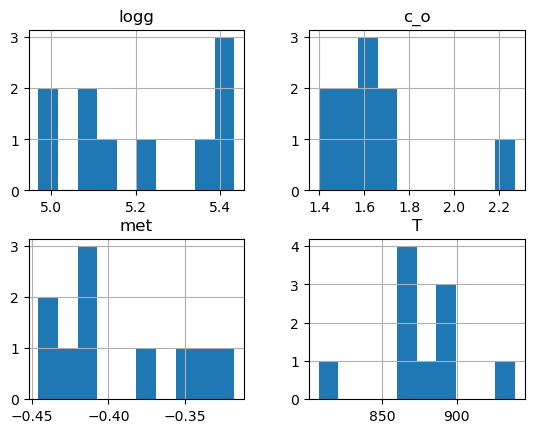

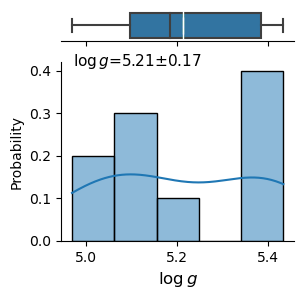

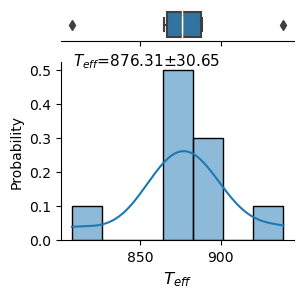

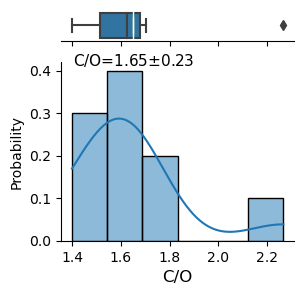

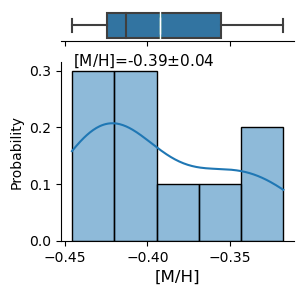

Radius = 0.79 R_Jup:  𝛘2 = 339.38, p-value = 0.00e+00


In [40]:
predict.predict_from_random_spectra(random_spectra_num= 10,
                                     __print_results__= True,
                                     __plot_randomly_generated_spectra__= True,
                                     __plot_histogram__= True,
                                     __plot_boxplot_hist__= True,
                                     __plot_pred_vs_obs_errorbar__= True,
                                     __plot_pred_vs_obs_errorbar_stat__ = True,
                                     __calculate_confidence_intervals_std_df__ = True,
                                    )

Comennet from natasha: >2.2 mincron - Is not missing any thing!
> 1 sigma error 
> training set
> trusing the posterior space 

### 2.4.4 Tune the Radius

 What is the 𝛘2 value for the predicted ML vs. the observational spectra?

In [41]:
chi_square_test(x_obs = predict.obs_data_df['wl'], 
                y_obs = predict.obs_data_df['Fnu_obs_absolute'], 
                yerr_obs = predict.obs_data_df['Fnu_obs_absolute_err'],
                
                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                y_pre = predict.confidence_intervals_std_df['mean'], 
                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                radius = brown_dwarf_literature_info['bd_radius_Rjup'],
                __plot_results__ = False,
                __print_results__ = True)

Radius = 0.79 R_Jup:  𝛘2 = 339.38, p-value = 0.00e+00


(339.38, '0.00e+00')

 What is the 𝛘2 value (and p-value) for a range of $R_{Jup}$ radius?

In [42]:
def tune_radius(Rmin = brown_dwarf_literature_info['bd_radius_Rjup']-0.1, 
                Rmax = brown_dwarf_literature_info['bd_radius_Rjup']+0.1, 
                dR=0.01,
                brown_dwarf_literature_info = None,
                __plot_results__ = False,
               __print_results__ = False,
               __plot_stat_results__ = False):
    
    R_list = []
    chi_square_list = []
    p_value_list = []
    random_pred_mean_list = []
 

    for radius in list( np.linspace(Rmin, Rmax, num=int((Rmax-Rmin)/dR) )):
        
        brown_dwarf_literature_info['bd_radius_Rjup_tuned'] = radius
        
        # brown_dwarf_literature_info 
        predict = ObserveParameterPredictor(
                                        object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                        training_dataset_df = train_BD,
                                        wl_synthetic = wl_synthetic, 
                                        bd_literature_dic = brown_dwarf_literature_info,
                                        trained_ML_model = trained_CNN_model,
                                        trained_X_ColWise_MinMax=trained_StandardScaler_X_ColWise_MinMax,
                                        trained_y_ColWise=trained_StandardScaler_y_ColWise,
                                        trained_X_RowWise=None,
                                        )

        predict.load_observational_spectra(
            __plot_observational_spectra_errorbar__=False,
            __replace_zeros_negatives_with_mean__=True,
            __print_results__=False,
            )
        
        predict.Process_Observational_Dataset(
            __print_results__=False,
            F_lambda_obs=None,
            F_lambda_obs_err=None    
                )

        predict.predict_from_random_spectra(random_spectra_num= 3,
                                             __print_results__= False,
                                             __plot_randomly_generated_spectra__= False,
                                             __plot_histogram__= False,
                                             __plot_boxplot_hist__= False,
                                             __plot_pred_vs_obs_errorbar__= False,
                                             __plot_pred_vs_obs_errorbar_stat__ = False,
                                             __calculate_confidence_intervals_std_df__ = True,
                                            )

        chi_square, p_value =  chi_square_test(x_obs = predict.obs_data_df['wl'], 
                                y_obs = predict.obs_data_df['Fnu_obs_absolute'], 
                                yerr_obs = predict.obs_data_df['Fnu_obs_absolute_err'],

                                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                                y_pre = predict.confidence_intervals_std_df['mean'], 
                                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                                radius = brown_dwarf_literature_info['bd_radius_Rjup'],
                                __plot_results__ = False,
                                __print_results__ = False)
        
        
        if chi_square >= 0.:

            R_list.append(radius)
            chi_square_list.append(chi_square)
            p_value_list.append(np.float64(p_value))
            random_pred_mean_list.append(list( predict.dic_random_pred_mean.values() ))
        else:
            pass

        if __print_results__:
            print( f"Radius = {'{:.2f}'.format(radius)} R_Jup:  𝛘2 = {chi_square}, p-value = {p_value}")
            
#     if __plot_stat_results__:
#         plot_chi_square_p_value(R_list, chi_square_list, p_value_list)
    
    tuned_ML_R_param_df = pd.DataFrame(columns=['radius','chi_square','p_value','gravity','temperature','c_o_ratio','metallicity'])
    tuned_ML_R_param_df['radius'] = R_list
    tuned_ML_R_param_df['chi_square'] = chi_square_list
    tuned_ML_R_param_df['p_value'] = p_value_list
    tuned_ML_R_param_df['gravity'] = np.array(random_pred_mean_list).T[0]
    tuned_ML_R_param_df['c_o_ratio'] = np.array(random_pred_mean_list).T[1]
    tuned_ML_R_param_df['metallicity'] = np.array(random_pred_mean_list).T[2]
    tuned_ML_R_param_df['temperature'] = np.array(random_pred_mean_list).T[3]

    return tuned_ML_R_param_df

In [43]:
print_results_fun(brown_dwarf_literature_info, print_title= 'GJ570D: Literature reported Info')

******************************

GJ570D: Literature reported Info

{   'bd_Teff': 828,
    'bd_distance_pc': 5.884,
    'bd_logg': 3.9,
    'bd_met': -0.33,
    'bd_name': 'GJ570D',
    'bd_radius_Rjup': 0.79,
    'bd_radius_Rjup_tuned': None}
******************************



In [44]:
tuned_ML_R_param_df = tune_radius(Rmin = brown_dwarf_literature_info['bd_radius_Rjup']- 0.2, 
                        Rmax = brown_dwarf_literature_info['bd_radius_Rjup']+ 0.2, 
                        dR = 0.01,
                        brown_dwarf_literature_info = brown_dwarf_literature_info,
                        __plot_results__=False,
                        __print_results__=False,
                        __plot_stat_results__=False,)

In [45]:
tuned_ML_R_param_df.describe()

,radius,chi_square,p_value,gravity,temperature,c_o_ratio,metallicity
count,39.000000,39.000000,3.900000e+01,39.000000,39.000000,39.000000,39.000000
mean,0.790000,1031.511538,6.548547e-06,5.217874,875.318607,1.579836,-0.391642
std,0.120018,1311.362404,3.807213e-05,0.104708,22.103901,0.146562,0.021726
min,0.590000,160.740000,0.000000e+00,4.860676,833.611633,1.198449,-0.433818
25%,0.690000,261.315000,0.000000e+00,5.181288,860.034149,1.486928,-0.404170
50%,0.790000,677.040000,0.000000e+00,5.210889,870.958435,1.564749,-0.395586
75%,0.890000,1163.185000,1.615000e-14,5.267354,886.837067,1.654446,-0.374949
max,0.990000,7351.240000,2.380000e-04,5.425325,937.824646,1.900362,-0.347078


In [46]:
tuned_ML_R_param_df.head()

,radius,chi_square,p_value,gravity,temperature,c_o_ratio,metallicity
0,0.590000,551.65,0.000000e+00,5.010017,937.824646,1.475945,-0.374902
1,0.600526,7351.24,0.000000e+00,5.340534,842.978821,1.870652,-0.420363
2,0.611053,1039.79,0.000000e+00,4.860676,910.888733,1.198449,-0.395586
3,0.621579,1650.92,0.000000e+00,5.181959,857.221680,1.545362,-0.398076
4,0.632105,226.81,2.650000e-11,5.425325,852.053650,1.864855,-0.426710


In [47]:

datuned_ML_R_param_df_filtered = tuned_ML_R_param_df[tuned_ML_R_param_df['p_value'].between(.01, 10.)]

plot_scatter_x_y(   x = datuned_ML_R_param_df_filtered['radius'],
                    y = datuned_ML_R_param_df_filtered['chi_square'],
                    plot_title='Scatter Plot',
                    x_label='Radius (RJupiter)',
                    y_label='𝛘2 value',
                    plot_width=800,
                    plot_height=300,)

---